In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [215]:
file = open('insurance.csv', 'r')
reader = csv.reader(file)
data = []

for row in reader:
	data.append(row)
print(data.pop(0))
data = np.array(data)

data[:, 1][data[:, 1] == 'male'] = 0
data[:, 1][data[:, 1] == 'female'] = 1
data[:, 4][data[:, 4] == 'no'] = 0
data[:, 4][data[:, 4] == 'yes'] = 1
data[:, 5][data[:, 5] == 'northeast'] = 0
data[:, 5][data[:, 5] == 'northwest'] = 1
data[:, 5][data[:, 5] == 'southeast'] = 2
data[:, 5][data[:, 5] == 'southwest'] = 3
data = data.astype(np.float64)

split_idx = int(len(data)*.8)


#normalize data
for i in range(len(data[0])):
	std = np.std(data[:,i])
	data[:,i] = data[:,i] - np.mean(data[:,i])
	data[:,i] = data[:,i]/std
	#data[:,i] = data[:,i]/np.std(data[:,i])

x_data_train = np.zeros((split_idx, 3))
x_data_train[:,0] = data[:split_idx, 0]
x_data_train[:,1] = data[:split_idx, 2]
x_data_train[:,2] = data[:split_idx, 3]
#x_data = data[:, :6].reshape((len(data), 6, 1))
y_data_train = data[:split_idx, 6]
print(x_data_train.shape)
print(x_data_train.shape)

x_data_test = np.zeros((len(data) - split_idx, 3))
x_data_test[:,0] = data[split_idx:, 0]
x_data_test[:,1] = data[split_idx:, 2]
x_data_test[:,2] = data[split_idx:, 3]
#x_data = data[:, :6].reshape((len(data), 6, 1))
y_data_test = data[split_idx:, 6]
print(x_data_test.shape)
print(x_data_test.shape)

# x_data_train = np.zeros((split_idx, 6))
# x_data_train = data[:split_idx]
# #x_data = data[:, :6].reshape((len(data), 6, 1))
# y_data_train = data[:split_idx, 6]
# print(x_data_train.shape)
# print(x_data_train.shape)

# x_data_test = np.zeros((len(data) - split_idx, 6))
# x_data_test = data[split_idx:]
# #x_data = data[:, :6].reshape((len(data), 6, 1))
# y_data_test = data[split_idx:, 6]
# print(x_data_test.shape)
# print(x_data_test.shape)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
(1070, 3)
(1070, 3)
(268, 3)
(268, 3)


In [216]:
# N = len(data)
# alpha = 2.3
# sigma = 2.
# slope = 4.
# x = np.random.normal (size=N)
# y = alpha + slope * x + sigma * np.random.normal(size=N)

data = {
	'N': len(x_data_train),
	'K': len(x_data_train[0]),
    'x': x_data_train,
    'y': y_data_train,

	'M': len(x_data_test),
	'x_test': x_data_test
}

In [217]:
program_code = """
data {
  //Train data
  int<lower=1> N;           // Number of samples
  int<lower=1> K;           // Number of predictors
  matrix[N, K] x;              // Covariate
  vector[N] y;              // Outcome

  //Test data
  int<lower=1> M;           // Number of test instances
  matrix[M, K] x_test;      // Covariates for test data
}

parameters {
  real alpha;               // Intercept
  row_vector[3] beta;       // Slope
  real<lower=0> sigma;      // Noise
}

model {
  // Priors
  sigma ~ inv_gamma(1, 1);     //tau0 = 1, tau1 = 1
  alpha ~ normal(0, 10);       //sigma_alhpa = 10
  beta ~ multi_normal(rep_vector(0, 3), diag_matrix(rep_vector(10, 3)));  //sigma_beta = 10

  // Likelihood
  for (n in 2:N)
    y[n] ~ normal(alpha + beta * x[n]', sigma);
}

generated quantities {
  vector[M] y_pred;
  
  for (m in 1:M) {
    y_pred[m] = normal_rng(alpha + x_test[m] * beta', sigma);
  }
}
"""

In [218]:
model = stan.build(program_code,data)
fit = model.sample(num_chains=3,num_warmup=1000,num_samples=3500)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/13500)
Sampling:   1% (101/13500)
Sampling:   1% (102/13500)
Sampling:   2% (301/13500)
Sampling:   4% (501/13500)
Sampling:   5% (700/13500)
Sampling:   7% (1000/13500)
Sampling:   9% (1200/13500)
Sampling:  11% (1500/13500)
Sampling:  13% (1700/13500)
Sampling:  15% (2000/13500)
Sampling:  16% (2200/13500)
Sampling:  44% (6000/13500)
Sampling:  72% (9700/13500)
Sampling: 100% (13500/13500)
Sampling: 100% (13500/13500), done.
Messages received during sampling:
  Gradient evaluation took 0.000836 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002449 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.004526 seconds
  1000 transitions using 10 leapfrog steps per transition would take 45.26 seconds.
  Adju

In [219]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,...,y_pred.259,y_pred.260,y_pred.261,y_pred.262,y_pred.263,y_pred.264,y_pred.265,y_pred.266,y_pred.267,y_pred.268
draws,,,,,,,,,,,,,,,,,,,,,
0,-458.588922,1.000000,0.796022,3.0,7.0,0.0,459.066445,0.018937,0.310884,0.147398,...,-0.121149,-0.496468,-0.701974,-0.718023,0.716226,0.576800,-1.011721,-1.033005,-0.960180,-0.043099
1,-457.570213,0.850198,0.736703,3.0,7.0,0.0,461.047642,-0.055665,0.311530,0.155285,...,-0.873859,0.372624,0.483795,1.100866,0.704715,0.665488,-0.010775,0.021085,-0.471082,-0.122023
2,-460.016105,0.988582,0.757087,3.0,7.0,0.0,460.833965,-0.013240,0.286901,0.235885,...,-0.597137,0.736469,0.631789,-0.789239,0.656332,0.079293,-1.124428,-1.495159,-0.358672,0.166590
3,-458.185145,0.992016,0.796022,3.0,7.0,0.0,460.757863,-0.074351,0.292641,0.167709,...,-0.846261,0.133004,0.334146,-0.444122,1.696599,-0.179962,-1.072414,1.174851,-0.053126,1.430748
4,-458.566790,0.735450,0.736703,2.0,7.0,0.0,462.916432,0.025732,0.262522,0.139132,...,1.305289,-0.127768,1.047882,-0.459796,1.533943,1.617270,-0.252639,0.593058,0.886803,0.646233


In [220]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.015,0.029,-0.068,0.041,0.000,0.000,12782.0,8112.0,1.0
beta[0],0.295,0.029,0.242,0.351,0.000,0.000,12028.0,7424.0,1.0
beta[1],0.158,0.029,0.104,0.211,0.000,0.000,12337.0,8291.0,1.0
beta[2],0.048,0.029,-0.005,0.104,0.000,0.000,12477.0,8592.0,1.0
sigma,0.930,0.020,0.890,0.967,0.000,0.000,12962.0,8082.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[263],0.304,0.926,-1.472,2.027,0.009,0.006,10345.0,10437.0,1.0
y_pred[264],-0.476,0.941,-2.269,1.293,0.009,0.007,10712.0,10226.0,1.0
y_pred[265],-0.345,0.924,-2.084,1.413,0.009,0.007,9891.0,10437.0,1.0
y_pred[266],-0.572,0.935,-2.262,1.231,0.009,0.007,10421.0,9843.0,1.0


/opt/anaconda3/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (273), generating only 20 plots
  warnings.warn(


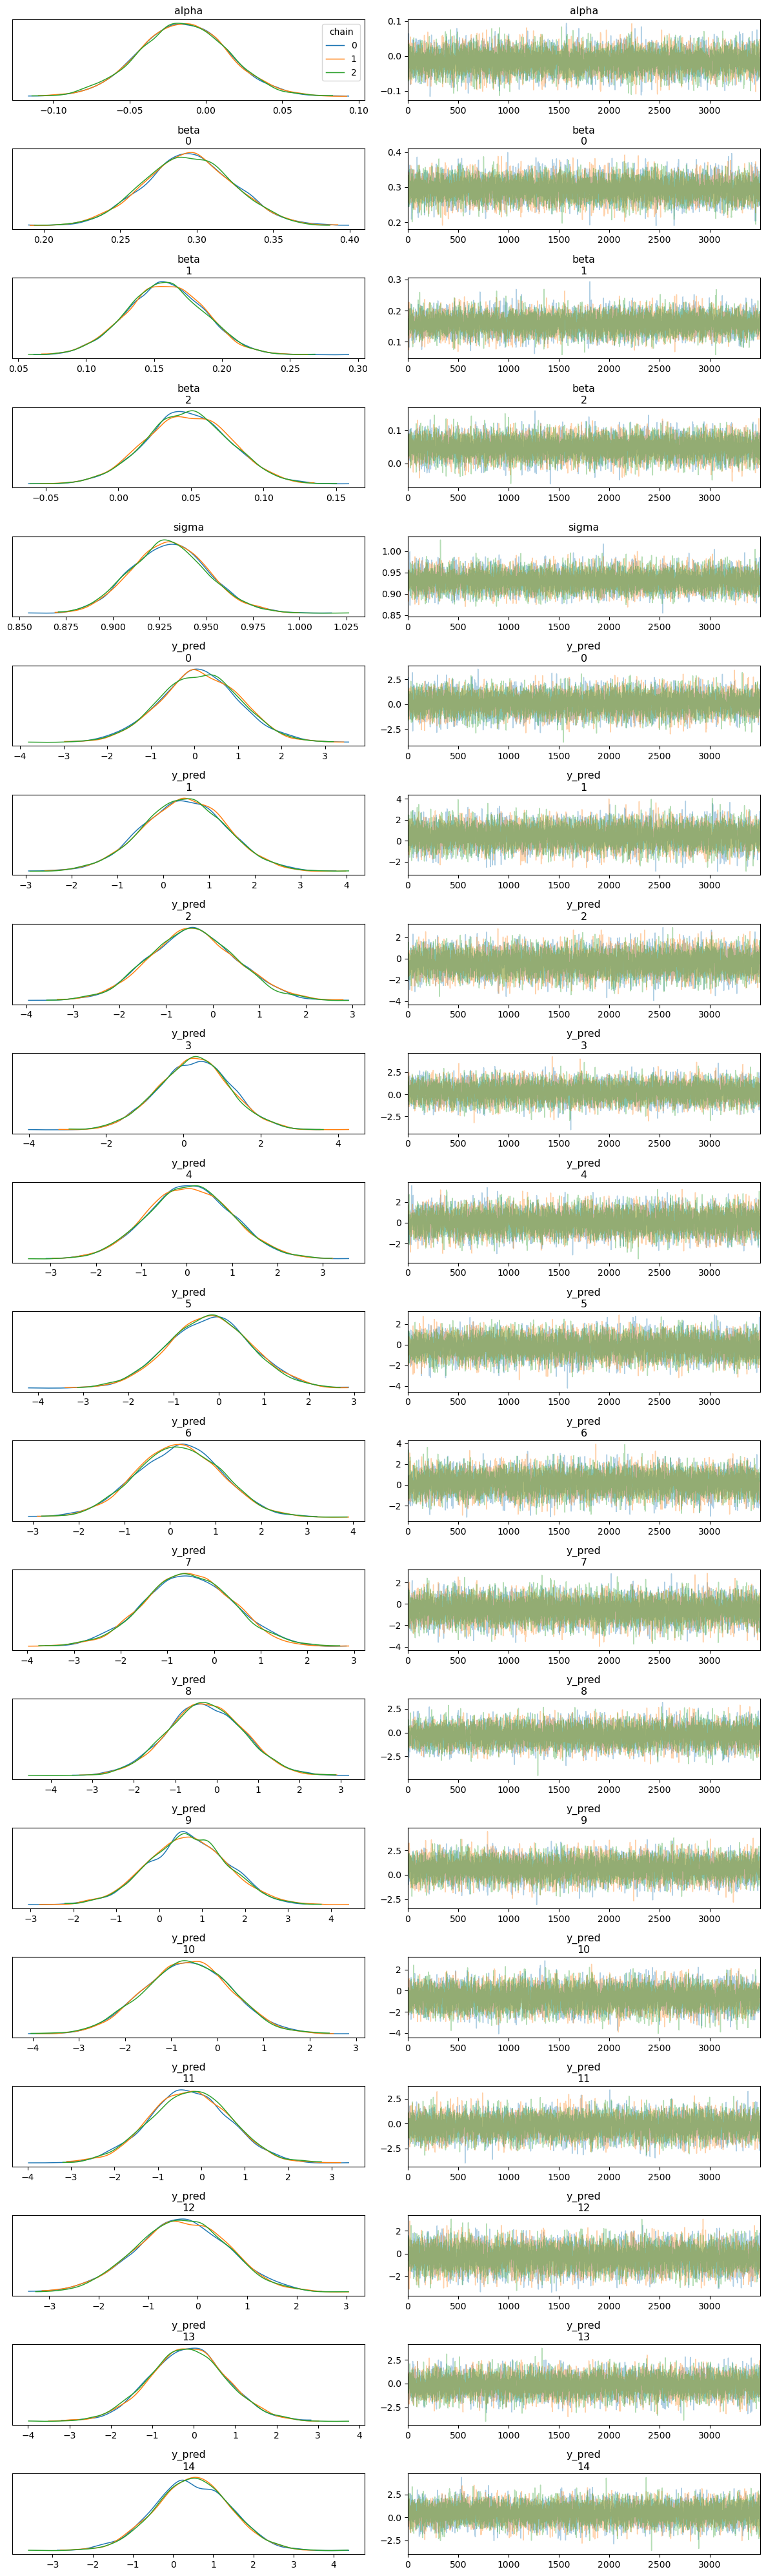

In [221]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

In [222]:
y_pred_samples = fit['y_pred']
y_pred_mean = np.mean(y_pred_samples, axis=1)

RMSE = np.sqrt((1/ data['M']) * np.sum((y_pred_mean - y_data_test) ** 2))
print(RMSE)


0.9787477566005377
